In [1]:
import pandas as pd
import numpy as np
import contact_networks as cn
import matplotlib.pyplot as plt
import tacoma as tc
import evaluation_networks as en
import random
import os
from math import ceil, sqrt
from scipy.stats import geom
from util import plot_contact_durations, moving_average

/home/scho_jj/.conda/envs/pandemic_networks_env/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'bayanpy', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


# Load Data

In [2]:
df_berlin = pd.read_csv('./VF_data/pandemos_tra_tapas_modell.csv')
df_rns = pd.read_csv('./VF_data/region_niedersachsen_tapas_modell.csv')

In [3]:
df_activities = pd.read_csv('./VF_data/activities.csv')
df_activities[['id', 'code_mct', 'name_mct', 'code_tapas', 'name_tapas', 'code_zbe', 'name_zbe']].sort_values('code_zbe')

,id,code_mct,name_mct,code_tapas,name_tapas,code_zbe,name_zbe
11,1,999,HOUSEWORK_AT_HOME,4,default,10,HOUSEWORK_AT_HOME
33,2,999,E_COMMERCE_OUT_OF_HOME,4,personal activities,12,E_COMMERCE_OUT_OF_HOME
40,3,999,HOUSEWORK_OUT_OF_HOME,4,personal activities,32,HOUSEWORK_OUT_OF_HOME
0,4,50,SHOPPING,3,shopping,50,SHOPPING
6,36,50,SHOPPING,3,shopping,51,SHOPPING SHORT TERM
24,37,50,SHOPPING,3,shopping,52,SHOPPING MID TERM
25,38,50,SHOPPING,3,shopping,53,SHOPPING LONG TERM
5,42,50,SHOPPING,3,shopping,54,SHOPPING RITA 1
19,43,50,SHOPPING,3,shopping,55,SHOPPING RITA 2
20,5,522,JOB_SEEKING,1,work,62,JOB_SEEKING


In [4]:
df_berlin = df_berlin[(df_berlin.loc_id_end < 100_000_000) & (df_berlin.loc_id_end >= 0)] # remove households
df_rns = df_rns[(df_rns.loc_id_end < 100_000_000) & (df_rns.loc_id_end >= 0)] # remove households

def location_specs(df):
    result = df.groupby('loc_id_end').agg({
        'activity': lambda x: x.mode().iloc[0],  # Most frequent activity
        'p_id': 'nunique',  # Unique nodes
        'activity_duration_min': ['sum', 'mean']  # Total time, mean time

    }).reset_index()

    # Rename columns 
    result.columns = ['loc_id_end', 'most_frequent_activity',  'unique_nodes', 'total_time', 'mean_time']
    return result

loc_specs_berlin = location_specs(df_berlin)
loc_specs_rns = location_specs(df_rns)

In [5]:
def total_time_and_nnodes(EN):
    # Empirical network
    EN.to_tacoma_tn()
    tn = EN.tn

    # Compute total time
    duration = EN.df_trajectories.activity_end_min - EN.df_trajectories.activity_start_min
    total_time = round(np.sum(duration) * 20/60)
    print(total_time)

    # Number of nodes
    nnodes = tn.N
    print(nnodes)
    return total_time, nnodes

def get_closest_locations(result, nnodes, total_time, nsmallest=10):
    # Assuming result is your DataFrame
    given_unique_nodes = nnodes  # Replace with your desired value
    given_total_time = total_time  # Replace with your desired value

    # Calculate the absolute relative differences
    result['diff_unique_nodes'] = abs((result['unique_nodes'] - given_unique_nodes) / given_unique_nodes)
    result['diff_total_time'] = abs((result['total_time'] - given_total_time) / given_total_time)

    # Calculate the combined absolute relative differences
    result['combined_diff'] = result['diff_unique_nodes'] + result['diff_total_time']

    # Find the top 5 closest rows
    closest_rows = result.nsmallest(nsmallest, 'combined_diff')

    return closest_rows  # RNS: 209315, 209385

# Highschool

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


edge list errors:  0
edge changes errors:  0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


edge list errors:  0
edge changes errors:  0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


edge list errors:  0
edge changes errors:  0
edge list errors:  0
edge changes errors:  0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


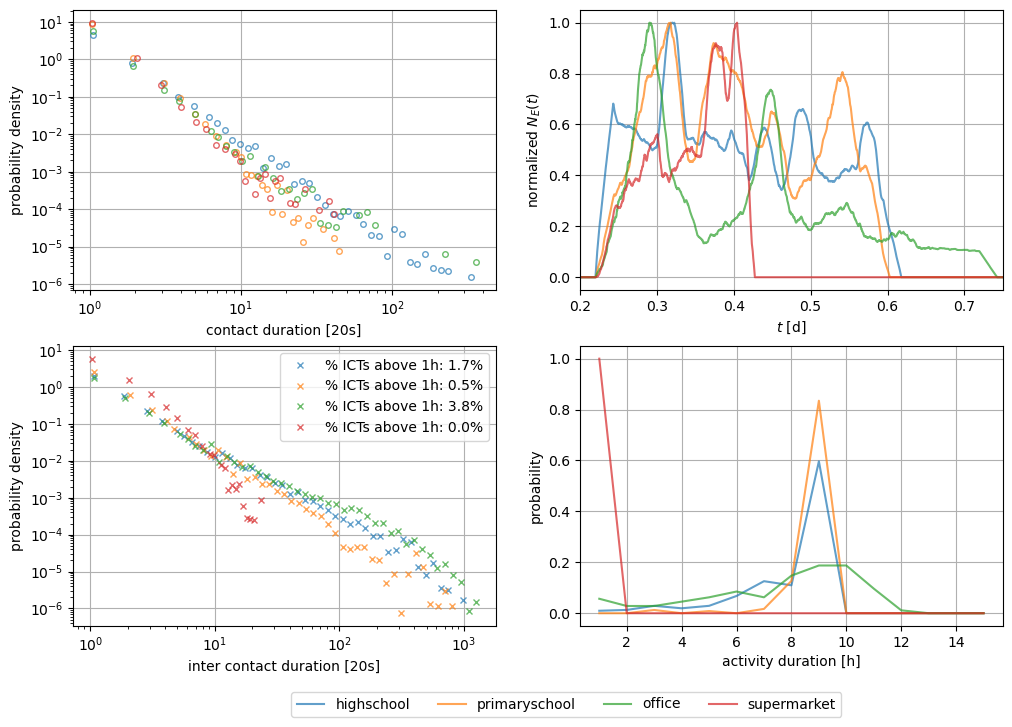

In [9]:
sot = 2000
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()
alpha=.7

path_of = './data_eval_split/InVS/f1_1970-01-01.parquet' 
path_hs = './data_eval_split/highschool/f0_2013-12-03.parquet'
path_ps = './data_eval_split/primaryschool/1970-01-01.parquet'
path_su = './data_eval_split/supermarked/f0_2021-03-17.parquet'

for path, ntype in zip([path_hs, path_ps, path_of, path_su], ['highschool', 'primaryschool', 'office', 'supermarked']):
    if ntype=='supermarked':
        new_time=20
        nlabel = 'supermarket'
    else:
        new_time=None
        nlabel = ntype

    EN_HS = en.EvaluationNetwork(ntype, path=path, TU=20, temporal_offset=1000, switch_off_time=sot, new_time=new_time)  # switch of nodes that have no links for at least 30min
    EN_HS.to_tacoma_tn()
    tn = EN_HS.tn
    res = tc.api.measure_group_sizes_and_durations(tn)
    quan = round(20 * np.quantile(res.group_durations[1], .99) / 60)
    quan = round(np.mean(np.array(res.group_durations[1]) > 180) * 100, 1)
    label = f'% ICTs above 1h: {quan}%'
    plot_contact_durations(res, (ax1, ax3), fit_power_law=True, bins=50, alpha=alpha, label=[None, label])

    _, _, m = tc.edge_counts(tn)
    smoothing=100
    m, t = moving_average(m[:-1], smoothing), moving_average(tn.t, smoothing)
    m = m / np.max(m)
    ax2.plot(t * 20/(24*60**2), m, alpha=alpha, label=nlabel)
    ax2.set(xlabel=r'$t$ [d]', ylabel=r'normalized $N_E(t)$', xlim=(.2, .75))

    duration = ((EN_HS.df_trajectories.activity_end_min - EN_HS.df_trajectories.activity_start_min ) *20/60**2).values
    hist, bins = np.histogram(duration, bins=range(16), density=True)

    ax4.plot(bins[1:], hist, label=nlabel, alpha=alpha)
    #EN_HS.df_trajectories.to_parquet(f'./{ntype}_animation_traj.parquet')
    ij = EN_HS.df[['i', 'j']].values.flatten()
    np.unique(ij).shape
    ax4.set(xlabel='activity duration [h]', ylabel='probability')

ax1.legend().remove()
#ax3.legend().remove()
ax4.legend(loc='lower left', bbox_to_anchor=(-.7, -.35), ncol=4)
#ax2.legend().remove()
ax1.set_xlabel('contact duration [20s]')
ax3.set_xlabel('inter contact duration [20s]')
#plt.tight_layout()

for ax in axs.flatten():
    ax.grid()

plt.savefig('./final_plots_paper/empirical_networks_comparisson.png')

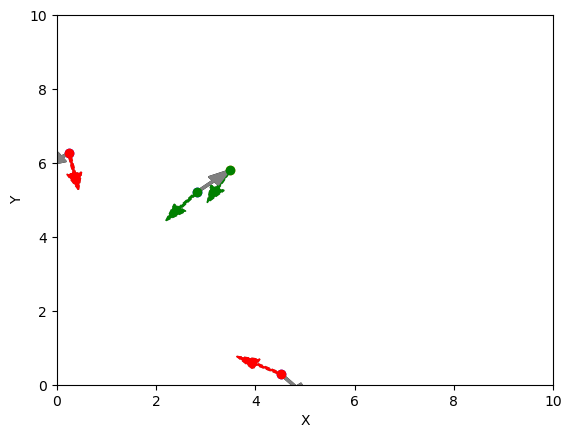

In [107]:
def generate_points(N):
    # Generate random points for array 1
    array1 = np.random.rand(N, 2) * 10  # Generating points in a 15x15 grid
    
    # Generate random points for array 2 with distances between 1 and 1.5 from array 1
    array2 = np.empty((N, 2))
    for i in range(N):
        distance = np.random.uniform(0, 2.0)  # Ensure distance is between 1 and 1.5
        angle = np.random.uniform(0, 2*np.pi)
        offset = np.array([distance * np.cos(angle), distance * np.sin(angle)])
        array2[i] = array1[i] + offset

    return array1, array2


def plot_points_and_vectors(points1, points2):
    N = len(points1)
    # Plot points
    plt.scatter(points1[:, 0], points1[:, 1], color='blue', label='Array 1')
    plt.scatter(points2[:, 0], points2[:, 1], color='orange', label='Array 2')

    for i in range(N):
        # Generate random vector for each point representing its line of sight
        vec_direction1 = np.random.rand(2) - 0.5  # Random direction vector for point 1
        vec_direction1 /= np.linalg.norm(vec_direction1)  # Normalize to unit vector
        vec_direction2 = np.random.rand(2) - 0.5  # Random direction vector for point 2
        vec_direction2 /= np.linalg.norm(vec_direction2)  # Normalize to unit vector
        
        # Plot line of sight vectors
        plt.arrow(points1[i, 0], points1[i, 1], vec_direction1[0], vec_direction1[1], 
                  color='gray', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
        plt.arrow(points2[i, 0], points2[i, 1], vec_direction2[0], vec_direction2[1], 
                  color='gray', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
        
        # Calculate distance between pair points
        distance = np.linalg.norm(points2[i] - points1[i])
        
        # Plot connecting vector between pair points
        plt.arrow(points1[i, 0], points1[i, 1], points2[i, 0] - points1[i, 0], points2[i, 1] - points1[i, 1],
                  color='black', linestyle='-', width=0.05, head_width=0.3, length_includes_head=True)
        
        # Calculate angle between line of sights and connecting vector
        conector = vec_direction2 - vec_direction1
        angle1 = np.arccos(np.dot(vec_direction1, conector) / (np.linalg.norm(vec_direction1) * np.linalg.norm(conector)))
        angle1_degrees = np.degrees(angle1)

        angle2 = np.arccos(-np.dot(vec_direction2, conector) / (np.linalg.norm(vec_direction2) * np.linalg.norm(conector)))
        angle2_degrees = np.degrees(angle2)
        #print(angle_degrees)
        
        # Check conditions and plot arrows and points accordingly
        if distance <= 1.5 and angle1_degrees <= 120 and angle2_degrees <= 120:
            plt.arrow(points1[i, 0], points1[i, 1], vec_direction1[0], vec_direction1[1], 
                      color='green', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
            plt.arrow(points2[i, 0], points2[i, 1], vec_direction2[0], vec_direction2[1], 
                      color='green', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
            plt.arrow(points1[i, 0], points1[i, 1], points2[i, 0] - points1[i, 0], points2[i, 1] - points1[i, 1],
                      color='gray', linestyle='-', width=0.05, head_width=0.3, length_includes_head=True)
            plt.scatter(points1[i, 0], points1[i, 1], color='green')
            plt.scatter(points2[i, 0], points2[i, 1], color='green')
        else:
            plt.arrow(points1[i, 0], points1[i, 1], vec_direction1[0], vec_direction1[1], 
                      color='red', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
            plt.arrow(points2[i, 0], points2[i, 1], vec_direction2[0], vec_direction2[1], 
                      color='red', linestyle='--', width=0.05, head_width=0.3, length_includes_head=True)
            plt.arrow(points1[i, 0], points1[i, 1], points2[i, 0] - points1[i, 0], points2[i, 1] - points1[i, 1],
                      color='gray', linestyle='-', width=0.05, head_width=0.3, length_includes_head=True)
            plt.scatter(points1[i, 0], points1[i, 1], color='red')
            plt.scatter(points2[i, 0], points2[i, 1], color='red')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.ylim(0, 10)
    plt.xlim(0, 10)

# Example usage
N = 3  # Number of points
points1, points2 = generate_points(N)
plot_points_and_vectors(points1, points2)

In [126]:
theory, model = [], []
phi_stars = np.arange(0, 200, 20)
for phi_star in phi_stars:
    N = 10_000  # Number of points
    points1, points2 = generate_points(N)
    angles1, angles2 = calculate_angles(points1, points2, plot=False)
    model.append(np.sum((angles1 <= phi_star/2) & (angles2 <= phi_star/2)) / N)

    theory.append((phi_star/360)**2)

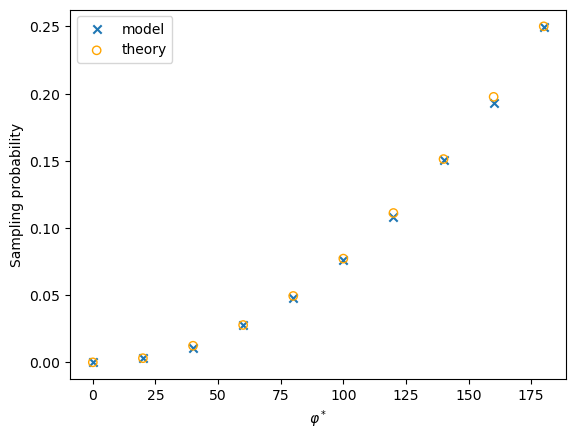

In [127]:
plt.scatter(phi_stars, model, marker='x', label='model')
plt.scatter(phi_stars, theory,  edgecolor='orange', facecolor='none', label='theory')
plt.xlabel(r'$\varphi^*$')
plt.ylabel('Sampling probability')
plt.legend()

In [94]:
sot = 2000
new_time = None
EN_HS = en.EvaluationNetwork('highschool', path=path_hs, TU=20, temporal_offset=1000, switch_off_time=sot, new_time=new_time)  # switch of nodes that have no links for at least 30min
EN_HS.to_tacoma_tn()
tn = EN_HS.tn
total_time_hs, nnodes_hs = total_time_and_nnodes(EN_HS)
closest_hs = get_closest_locations(loc_specs_berlin, nnodes_hs, total_time_hs, nsmallest=1000)
closest_hs[closest_hs.most_frequent_activity == 410]

,loc_id_end,most_frequent_activity,unique_nodes,total_time,mean_time,diff_unique_nodes,diff_total_time,combined_diff
1431,1557,410,327,117287,306.232376,0.000000,0.152250,0.152250
46255,50711,410,327,116270,294.354430,0.000000,0.159601,0.159601
193331,209654,410,341,120741,306.449239,0.042813,0.127285,0.170098
208755,226079,410,324,115738,308.634667,0.009174,0.163447,0.172621
473,497,410,347,121984,307.264484,0.061162,0.118301,0.179463
...,...,...,...,...,...,...,...,...
193242,209562,410,214,71977,311.588745,0.345566,0.479751,0.825317
261265,283641,410,217,70639,289.504098,0.336391,0.489422,0.825813
3796,4169,410,209,73031,306.852941,0.360856,0.472132,0.832989
192890,209209,410,212,71043,287.623482,0.351682,0.486502,0.838184


<Axes: >

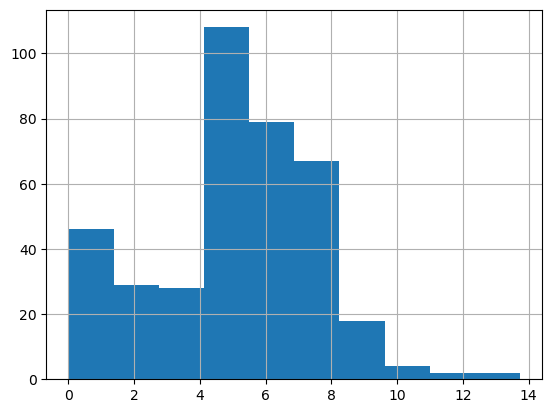

In [95]:
df_hs_tapas = df_berlin[df_berlin.loc_id_end == 1557]
#df_hs_tapas.to_parquet('./networks/highschool/tapas_highschool_trajectory.parquet')
(df_hs_tapas.activity_duration_min / 60).hist()

# TAPAS office

1.0

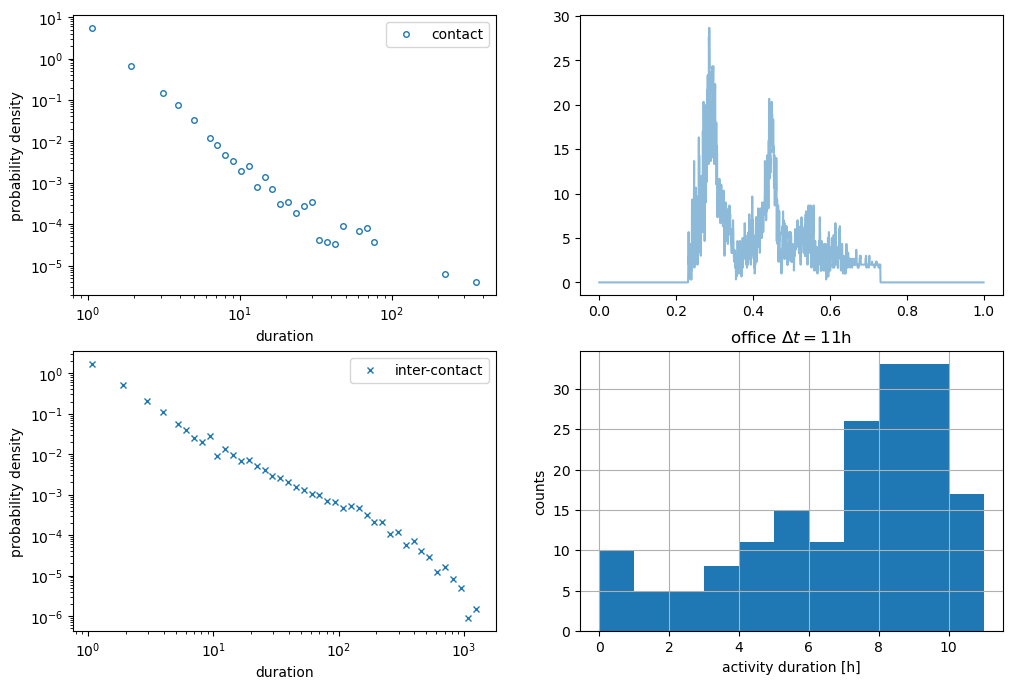

In [39]:
path_office = './data_eval_split/InVS/f1_1970-01-01.parquet'
sot = 2000
EN_O = en.EvaluationNetwork('office', path=path_office, TU=20, temporal_offset=1000, switch_off_time=sot)  # switch of nodes that have no links for at least 30min

EN_O.to_tacoma_tn()
tn = EN_O.tn

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

res = tc.api.measure_group_sizes_and_durations(tn)

plot_contact_durations(res, (ax1, ax3), fit_power_law=True, bins=50, xlabel='duration')

_, _, m = tc.edge_counts(tn)
smoothing=3
m, t = moving_average(m[:-1], smoothing), moving_average(tn.t, smoothing)
ax2.plot(t * 20/(24*60**2), m, alpha=.5)

duration = (EN_O.df_trajectories.activity_end_min - EN_O.df_trajectories.activity_start_min ) *20/60**2
duration.hist(bins=range(0, 12), ax=ax4)
ax4.set(xlabel='activity duration [h]', ylabel='counts', title=r'office $\Delta t = $'+f'{round(sot*20/60**2)}h')
ict = np.array(res.group_durations[1])
np.sum(ict<=sot) / len(ict)

In [31]:
total_time_hs, nnodes_hs = total_time_and_nnodes(EN_O)
total_time_office, nnodes_office = total_time_and_nnodes(EN_O)
print(total_time_office, nnodes_office)

closest = get_closest_locations(loc_specs_berlin, nnodes_office, total_time_office, 1000)
closest[closest.most_frequent_activity == 212]

NameError: name 'total_time_and_nnodes' is not defined

In [71]:
df_of_tapas = df_berlin[df_berlin.loc_id_end == 126861]
df_of_tapas.to_parquet('./networks/office/tapas_office_trajectory.parquet')

# Primary school

1.0

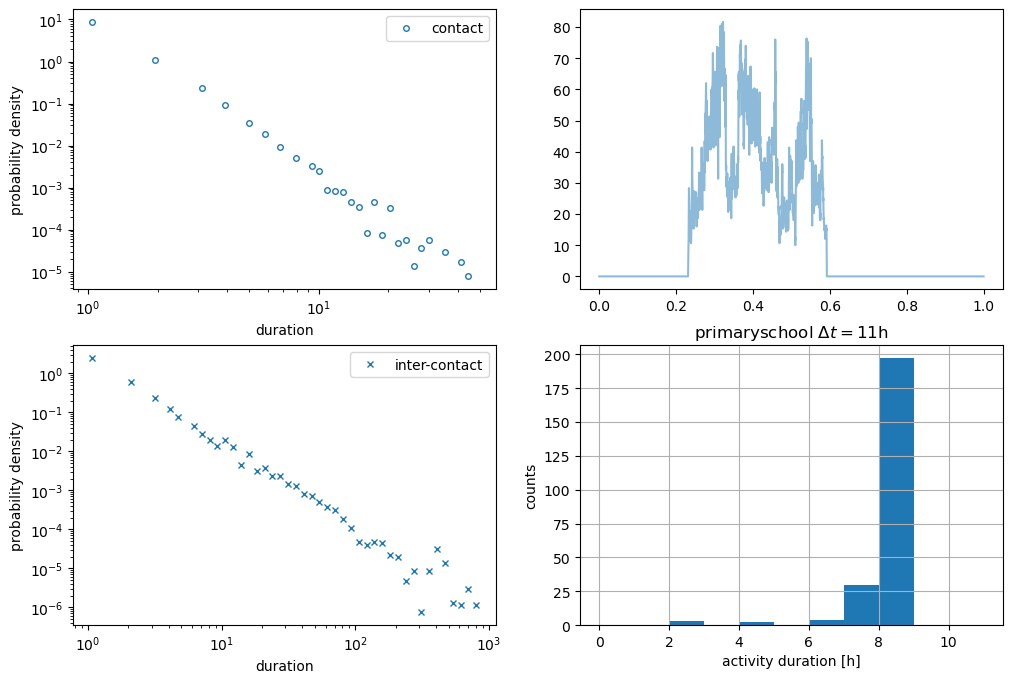

In [37]:
path_ps = './data_eval_split/primaryschool/1970-01-01.parquet'
sot = 2000
EN_PS = en.EvaluationNetwork('primaryschool', path=path_ps, TU=20, temporal_offset=1000, switch_off_time=sot)  # switch of nodes that have no links for at least 30min

EN_PS.to_tacoma_tn()
tn = EN_PS.tn

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

res = tc.api.measure_group_sizes_and_durations(tn)

plot_contact_durations(res, (ax1, ax3), fit_power_law=True, bins=50, xlabel='duration')

_, _, m = tc.edge_counts(tn)
smoothing=3
m, t = moving_average(m[:-1], smoothing), moving_average(tn.t, smoothing)
ax2.plot(t * 20/(24*60**2), m, alpha=.5)

duration = (EN_PS.df_trajectories.activity_end_min - EN_PS.df_trajectories.activity_start_min ) *20/60**2
duration.hist(bins=range(0, 12), ax=ax4)
ax4.set(xlabel='activity duration [h]', ylabel='counts', title=r'primaryschool $\Delta t = $'+f'{round(sot*20/60**2)}h')
ict = np.array(res.group_durations[1])
# tc.write_json_taco(tn, './networks/primaryschool/empirical.taco')
np.sum(ict<=sot) / len(ict)

Text(0, 0.5, '$\\bar N_g$ distribution')

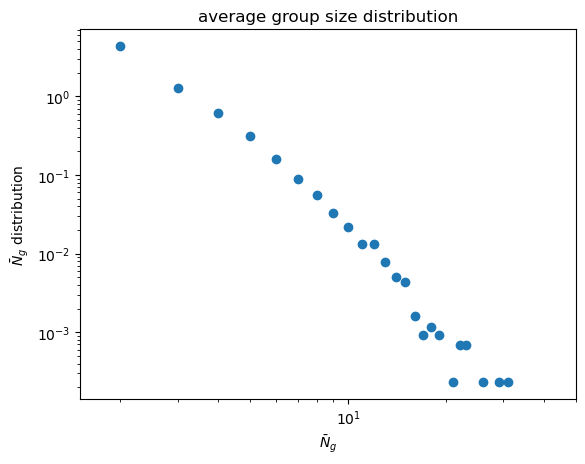

In [18]:
size_hist = res.aggregated_size_histogram[2:]
plt.scatter(range(2, len(size_hist) + 2), size_hist)
plt.xlim(1.5, 50)
plt.yscale('log')
plt.xscale('log')
plt.title('average group size distribution')
plt.xlabel(r'$\bar N_g$')
plt.ylabel(r'$\bar N_g$ distribution')

In [42]:
total_time_hs, nnodes_hs = total_time_and_nnodes(EN_PS)
total_time_office, nnodes_office = total_time_and_nnodes(EN_PS)
print(total_time_office, nnodes_office)

closest = get_closest_locations(loc_specs_rns, nnodes_office, total_time_office, 1000)
closest[closest.most_frequent_activity == 410]

,loc_id_end,most_frequent_activity,unique_nodes,total_time,mean_time,diff_unique_nodes,diff_total_time,combined_diff
14573,20143,410,247,90379,322.782143,0.020661,0.212191,0.232852
3315,5091,410,254,88511,327.818519,0.049587,0.228474,0.278061
46362,65315,410,259,90236,329.328467,0.070248,0.213438,0.283686
71865,101147,410,244,82719,312.147170,0.008264,0.278961,0.287226
2595,4330,410,271,95014,316.713333,0.119835,0.171789,0.291624
...,...,...,...,...,...,...,...,...
55652,78302,410,163,46268,255.624309,0.326446,0.596695,0.923141
109039,153082,410,157,48702,283.151163,0.351240,0.575478,0.926718
106466,149649,410,146,52424,340.415584,0.396694,0.543034,0.939729
62059,87476,410,153,48853,294.295181,0.367769,0.574162,0.941930


In [74]:
df_ps_tapas = df_rns[df_rns.loc_id_end == 20143]
df_ps_tapas#.to_parquet('./networks/primaryschool/tapas_primaryschool_trajectory.parquet')

,p_id,hh_id,scheme_id,score_combined,score_finance,score_time,taz_id_start,taz_has_toll_start,block_id_start,loc_id_start,...,is_home,activity_start_min,activity_duration_min,car_index,is_restricted,p_group,taz_bbr_type_start,bbr_type_home,loc_selection_motive,loc_selection_motive_supply
122163,100446264,100253197,29020,0.999979,1.0,1.0,474,f,-1,-100253197,...,f,450,330,-1,f,1,72,72,0,0
166007,100706646,100376528,33235,0.026920,0.0,0.0,691,f,-1,-100376528,...,f,480,480,-1,f,1,73,73,0,0
327300,100529684,100293480,112968,0.093564,1.0,1.0,586,f,-1,-100293480,...,f,496,207,-1,f,1,73,73,0,0
327302,100529684,100293480,112968,0.093564,1.0,1.0,586,f,-1,-100293480,...,f,1025,17,0,f,1,73,73,0,0
465480,100705171,100375749,101074,0.045225,0.0,0.0,690,f,-1,-100375749,...,f,465,315,0,f,1,74,74,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8447818,100647043,100349367,81918,0.013408,0.0,0.0,650,f,-1,-100349367,...,f,502,467,0,f,1,73,73,0,0
8499007,100572229,100314122,16112,0.033970,0.0,0.0,589,f,-1,-100314122,...,f,580,370,-1,f,1,73,73,0,0
8535252,100592104,100324078,74744,0.022580,0.0,0.0,610,f,-1,-100324078,...,f,440,430,0,f,1,73,73,0,0
8597797,100571902,100314046,90513,0.992839,1.0,1.0,589,f,-1,-100314046,...,f,453,325,-1,f,1,73,73,0,0


# Get capacities of TAPAS locations

In [84]:
df_capas_berlin = pd.read_csv('./VF_data/berlin_loc_capas.csv')
df_capas_rns = pd.read_csv('./VF_data/ns_loc_capas.csv')

# office =126861, highschool=1557,
df_capas_berlin[df_capas_berlin.loc_id == 126861]

,loc_id,loc_capacity
146074,126861,344


In [86]:
# office =126861, highschool=1557,
df_capas_berlin[df_capas_berlin.loc_id == 1557]

,loc_id,loc_capacity
204129,1557,1161


In [83]:
#primaryschool=20143
df_capas_rns[df_capas_rns.loc_id == 20143]

,loc_id,loc_capacity
137001,20143,307


# Supermarked

1.0

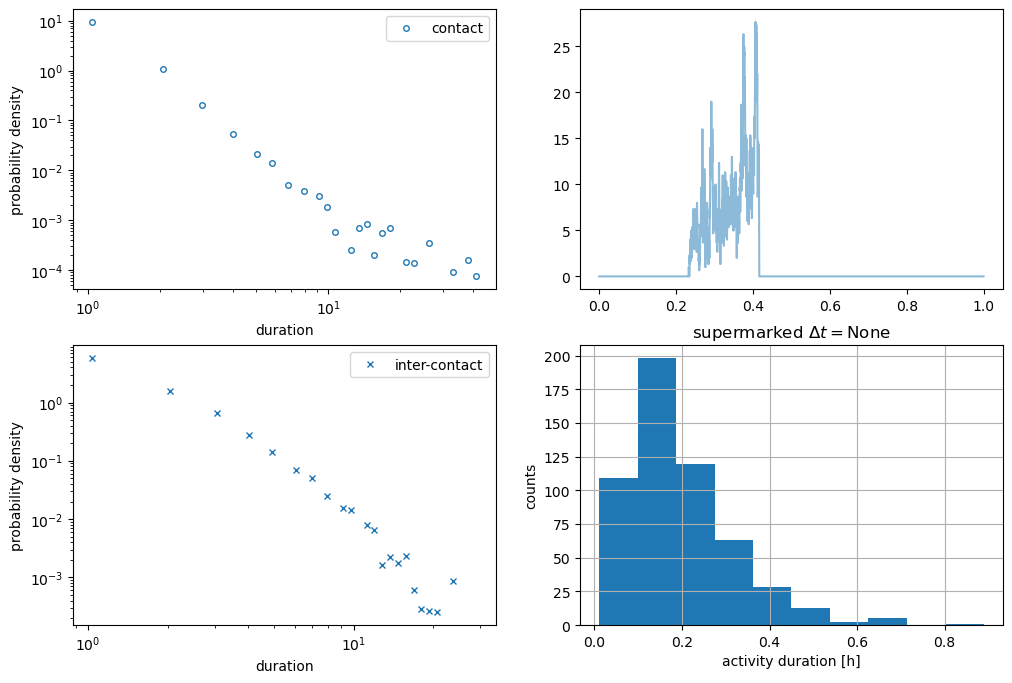

In [20]:
path_su = './data_eval_split/supermarked/f0_2021-03-17.parquet'
sot = 360
EN_O = en.EvaluationNetwork('supermarked', path=path_su, TU=20, new_time=20, temporal_offset=1000, switch_off_time=sot)  # switch of nodes that have no links for at least 30min

EN_O.to_tacoma_tn()
tn = EN_O.tn

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
ax1, ax2, ax3, ax4 = axs.flatten()

res = tc.api.measure_group_sizes_and_durations(tn)

plot_contact_durations(res, (ax1, ax3), fit_power_law=True, bins=50, xlabel='duration')

_, _, m = tc.edge_counts(tn)
smoothing=3
m, t = moving_average(m[:-1], smoothing), moving_average(tn.t, smoothing)
ax2.plot(t * 20/(24*60**2), m, alpha=.5)

duration = (EN_O.df_trajectories.activity_end_min - EN_O.df_trajectories.activity_start_min ) *20/60**2
duration.hist(bins=10, ax=ax4)
ax4.set(xlabel='activity duration [h]', ylabel='counts', title=r'supermarket $\Delta t = $None')

ict = np.array(res.group_durations[1])
tc.write_json_taco(tn, './networks/supermarked/empirical.taco')
np.sum(ict<=sot) / len(ict)

Text(0, 0.5, '$\\bar N_g$ distribution')

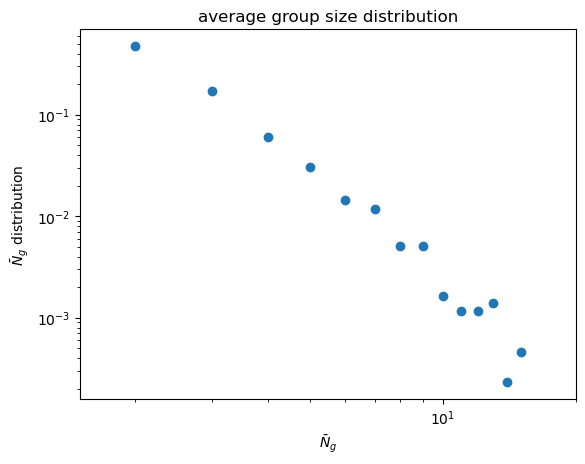

In [41]:
size_hist = res.aggregated_size_histogram[2:]
plt.scatter(range(2, len(size_hist) + 2), size_hist)
plt.xlim(1.5, 20)
plt.yscale('log')
plt.xscale('log')
plt.title('average group size distribution')
plt.xlabel(r'$\bar N_g$')
plt.ylabel(r'$\bar N_g$ distribution')

## Export best school guess

In [223]:
df_uni = df_rns[df_rns.loc_id_end == 147746][['loc_id_end', 'p_id', 'activity', 'activity_start_min', 'activity_duration_min']]
df_school = df_rns[df_rns.loc_id_end == 153466][['loc_id_end', 'p_id', 'activity', 'activity_start_min', 'activity_duration_min']]

print('Uni min/max time', df_uni.activity_start_min.min(), df_uni.activity_start_min.max())
print('Uni min/max time', df_school.activity_start_min.min(), df_school.activity_start_min.max())

for df in [df_uni, df_school]:
    df['activity_end_min'] = df['activity_start_min'] + df['activity_duration_min']
    

df_uni.to_parquet('./VF_data/rns_uni_location.parquet')
df_school.to_parquet('./VF_data/rns_school_location.parquet')

Uni min/max time 347 1390
Uni min/max time 335 1206


(0.0, 1440.0)

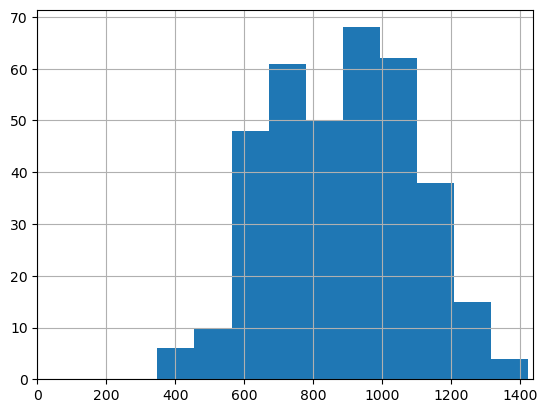

In [229]:
df_uni.activity_end_min.hist()
plt.xlim(0, 1440)

# TAPAS supermarked
## Find best fit to empirical supermarked in TAPAS data

In [173]:
path_supermarked = './data_eval_split/supermarked/'
files_supermarked = os.listdir(path_supermarked)
EN_S = en.EvaluationNetwork('supermarked', path_supermarked + files_supermarked[0], new_time=20, switch_off_time=None)  # switch of nodes that have no links for at least 30min

total_time_supermarked, nnodes_supermarked = total_time_and_nnodes(EN_S)

0 795
edge list errors:  0
edge changes errors:  0
6276
539


In [174]:
get_closest_locations(loc_specs_berlin, nnodes_supermarked, total_time_supermarked, 10)
# best guess berlin: 202376 .73

,loc_id_end,most_frequent_activity,unique_nodes,total_time,mean_time,diff_unique_nodes,diff_total_time,combined_diff
187129,202376,51,166,6519,38.573964,0.692022,0.038719,0.730741
189271,204621,51,145,6211,42.251701,0.730983,0.010357,0.741340
259450,281655,51,153,6092,39.558442,0.716141,0.029318,0.745459
187180,202427,51,162,6659,37.621469,0.699443,0.061026,0.760470
227,241,50,132,6323,47.901515,0.755102,0.007489,0.762591
183490,198574,51,165,6729,40.053571,0.693878,0.072180,0.766057
2141,2333,51,166,6758,39.290698,0.692022,0.076801,0.768823
186166,201370,51,135,6440,47.007299,0.749536,0.026131,0.775667
187209,202456,51,121,6278,51.040650,0.775510,0.000319,0.775829
3440,3781,51,139,6052,40.891892,0.742115,0.035692,0.777807


In [175]:
get_closest_locations(loc_specs_rns, nnodes_supermarked, total_time_supermarked, 10)
# best guess rns: 158905 .57

,loc_id_end,most_frequent_activity,unique_nodes,total_time,mean_time,diff_unique_nodes,diff_total_time,combined_diff
113248,158905,51,230,6273,26.468354,0.573284,0.000478,0.573762
54218,76027,51,238,6411,26.167347,0.558442,0.021511,0.579952
78742,110911,51,242,6517,26.491870,0.551020,0.038400,0.589421
78784,111004,53,207,6120,27.818182,0.615955,0.024857,0.640812
87384,122795,51,183,6320,33.617021,0.660482,0.007011,0.667493
102614,144041,53,179,6296,34.784530,0.667904,0.003187,0.671090
25022,34891,51,228,6882,28.556017,0.576994,0.096558,0.673553
65567,92214,51,182,6406,34.256684,0.662338,0.020714,0.683051
18468,25551,51,184,6436,33.873684,0.658627,0.025494,0.684121
83544,117590,51,250,7249,27.880769,0.536178,0.155035,0.691213


In [176]:
# loc_specs[ (loc_specs.unique_nodes > 300) & (loc_specs.unique_nodes < 600) & (loc_specs.total_time < 15_000)] 
# loc_specs[(loc_specs.total_time < 7000) & (loc_specs.total_time > 6000)] 
loc_specs_rns[(loc_specs_rns.unique_nodes < 600) & (loc_specs_rns.unique_nodes > 500)] 

,loc_id_end,most_frequent_activity,unique_nodes,total_time,mean_time,diff_unique_nodes,diff_total_time,combined_diff
16,17,212,512,215055,376.628722,0.050093,33.266252,33.316345
404,436,522,572,44055,76.884817,0.061224,6.019598,6.080823
435,467,740,589,45693,76.537688,0.092764,6.280593,6.373357
440,472,799,532,44471,83.592105,0.012987,6.085883,6.098870
442,474,522,527,39366,74.698292,0.022263,5.272467,5.294730
...,...,...,...,...,...,...,...,...
135912,220749,740,522,40773,77.662857,0.031540,5.496654,5.528194
135917,220754,740,538,46758,86.749536,0.001855,6.450287,6.452142
135951,220788,799,516,37135,71.413462,0.042672,4.916985,4.959657
135976,220813,799,530,38641,70.512774,0.016698,5.156947,5.173645


In [100]:
EN_S.df

,timestamp,reporting_id,opposing_id,distance,condition_id,group_id,i,j,i_start,i_end,j_start,j_end,i_start_seconds,i_end_seconds,j_start_seconds,j_end_seconds,t,date,day
0,2021-03-17 12:21:47,210562_2021-03-17_12:21:33_12:27:25,210451_2021-03-17_12:21:15_12:29:19,141.0,1.0,None,177,290,2021-03-17 12:21:33,2021-03-17 12:27:25,2021-03-17 12:21:15,2021-03-17 12:29:19,104,456,86,570,5,2021-03-17 12:21:47,2021-03-17
1,2021-03-17 12:21:49,210562_2021-03-17_12:21:33_12:27:25,210451_2021-03-17_12:21:15_12:29:19,85.0,1.0,None,177,290,2021-03-17 12:21:33,2021-03-17 12:27:25,2021-03-17 12:21:15,2021-03-17 12:29:19,104,456,86,570,6,2021-03-17 12:21:49,2021-03-17
2,2021-03-17 12:22:23,210516_2021-03-17_12:19:49_12:31:52,210510_2021-03-17_12:22:12_12:28:50,192.0,1.0,None,261,265,2021-03-17 12:19:49,2021-03-17 12:31:52,2021-03-17 12:22:12,2021-03-17 12:28:50,0,723,143,541,7,2021-03-17 12:22:23,2021-03-17
3,2021-03-17 12:22:52,210662_2021-03-17_12:22:07_12:43:27,210436_2021-03-17_12:22:21_12:34:04,107.0,1.0,None,160,362,2021-03-17 12:22:07,2021-03-17 12:43:27,2021-03-17 12:22:21,2021-03-17 12:34:04,138,1418,152,855,9,2021-03-17 12:22:52,2021-03-17
4,2021-03-17 12:23:11,210662_2021-03-17_12:22:07_12:43:27,210436_2021-03-17_12:22:21_12:34:04,84.0,1.0,None,160,362,2021-03-17 12:22:07,2021-03-17 12:43:27,2021-03-17 12:22:21,2021-03-17 12:34:04,138,1418,152,855,10,2021-03-17 12:23:11,2021-03-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6655,2021-03-17 16:44:53,208711_2021-03-17_16:41:18_16:45:00,208543_2021-03-17_16:41:53_16:45:00,138.0,1.0,None,33,84,2021-03-17 16:41:18,2021-03-17 16:45:00,2021-03-17 16:41:53,2021-03-17 16:45:00,15689,15911,15724,15911,795,2021-03-17 16:44:53,2021-03-17
6656,2021-03-17 16:44:53,210788_2021-03-17_16:37:54_16:45:00,210417_2021-03-17_16:33:22_16:45:00,164.0,1.0,None,143,475,2021-03-17 16:37:54,2021-03-17 16:45:00,2021-03-17 16:33:22,2021-03-17 16:45:00,15485,15911,15213,15911,795,2021-03-17 16:44:53,2021-03-17
6657,2021-03-17 16:44:54,210988_2021-03-17_16:30:17_16:45:00,210788_2021-03-17_16:37:54_16:45:00,57.0,1.0,None,475,484,2021-03-17 16:30:17,2021-03-17 16:45:00,2021-03-17 16:37:54,2021-03-17 16:45:00,15028,15911,15485,15911,795,2021-03-17 16:44:54,2021-03-17
6658,2021-03-17 16:44:57,210440_2021-03-17_16:21:46_16:45:00,208647_2021-03-17_16:32:00_16:45:00,166.0,1.0,None,48,168,2021-03-17 16:21:46,2021-03-17 16:45:00,2021-03-17 16:32:00,2021-03-17 16:45:00,14517,15911,15131,15911,795,2021-03-17 16:44:57,2021-03-17


# Stochastic conciderations and the role of $\gamma$

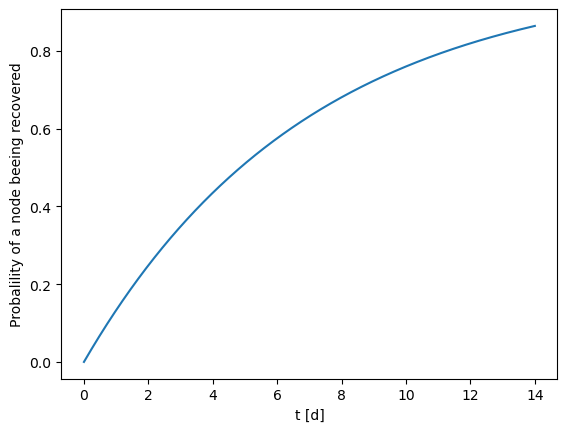

In [14]:
# geom = geometric distribution
# daily resolution
x = np.arange(0, 14 + 1, 1)
cdf = geom.cdf(x, p=1/7)

# 20 sec resolution
x20 = np.arange(0, 14*24*60*60/20 + 1, 1)
cdf20 = geom.cdf(x20, p=20/(7*24*60*60))

# plt.scatter(x, cdf)
plt.plot(20* x20/(24*60*60), cdf20)
plt.xlabel('t [d]')
plt.ylabel('Probalility of a node beeing recovered')
pass

In [128]:
total_jurij = 105.81 + 97.19 + 102.26 + 19.6
total_jurij

324.86

In [130]:
anteil_pp_jurij = total_jurij / 2 
anteil_pp_mascha = (170 + 20 + 10) / 2

anteil_pp_jurij - anteil_pp_mascha + 12

74.43